In [1]:
####### Mouting Drive #######
from google.colab import drive
drive.mount('/content/drive')
!ls

Mounted at /content/drive
drive  sample_data


In [2]:
!unzip "/content/drive/MyDrive/Selfie_Images/EX_Selfie&Selfie_Dataset.zip"

Archive:  /content/drive/MyDrive/Selfie_Images/EX_Selfie&Selfie_Dataset.zip
   creating: EX_Selfie&Selfie_Dataset/
   creating: EX_Selfie&Selfie_Dataset/EX_Selfie&Selfie/
   creating: EX_Selfie&Selfie_Dataset/EX_Selfie&Selfie/Extreme_selfie/
  inflating: EX_Selfie&Selfie_Dataset/EX_Selfie&Selfie/Extreme_selfie/images 1 (1).jpg  
  inflating: EX_Selfie&Selfie_Dataset/EX_Selfie&Selfie/Extreme_selfie/images 1 (10).jpg  
  inflating: EX_Selfie&Selfie_Dataset/EX_Selfie&Selfie/Extreme_selfie/images 1 (100).jpg  
  inflating: EX_Selfie&Selfie_Dataset/EX_Selfie&Selfie/Extreme_selfie/images 1 (101).jpg  
  inflating: EX_Selfie&Selfie_Dataset/EX_Selfie&Selfie/Extreme_selfie/images 1 (102).jpg  
  inflating: EX_Selfie&Selfie_Dataset/EX_Selfie&Selfie/Extreme_selfie/images 1 (103).jpg  
  inflating: EX_Selfie&Selfie_Dataset/EX_Selfie&Selfie/Extreme_selfie/images 1 (104).jpg  
  inflating: EX_Selfie&Selfie_Dataset/EX_Selfie&Selfie/Extreme_selfie/images 1 (105).jpg  
  inflating: EX_Selfie&Selfie_Dat

In [3]:
import os
os.chdir('/content/EX_Selfie&Selfie_Dataset')
!ls

'EX_Selfie&Selfie'   train_test_split


In [4]:
pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import splitfolders

In [6]:
splitfolders.ratio("/content/EX_Selfie&Selfie_Dataset/EX_Selfie&Selfie", output="/content/EX_Selfie&Selfie_Dataset/train_test_split",
    seed=42, ratio=(.8, .2), group_prefix=None) # default values

Copying files: 1318 files [00:00, 7656.73 files/s]


In [7]:
# import the libraries as shown below

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
#from tensorflow.keras.applications.inception_v3 import InceptionV3
#from keras.applications.vgg19 import VGG19
#from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.mobilenet_v2 import preprocess_input as pi

In [8]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

In [9]:
train_path = '/content/EX_Selfie&Selfie_Dataset/train_test_split/train'
valid_path = '/content/EX_Selfie&Selfie_Dataset/train_test_split/val'

In [10]:
# add preprocessing layer to the front of VGG
mblv2 = MobileNetV2(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

9420800/9406464 [==============================] - 0s 0us/step


In [11]:
# don't train existing weights
for layer in mblv2.layers:
  layer.trainable = False

In [24]:
 # useful for getting number of classes
folders = glob('/content/EX_Selfie&Selfie_Dataset/train_test_split/train/*')

In [25]:
# our layers - you can add more if you want
x = Flatten()(mblv2.output)
# x = Dense(2, activation='relu')(x)
prediction = Dense(len(folders), activation='sigmoid')(x)

In [26]:
# create a model object
MobileNet_V2_model = Model(inputs=mblv2.input, outputs=prediction)

In [27]:
#################### Add Prefix of MobileNet_V2_ on each layer of the Pre-Defined Model ###################################
import tensorflow as tf

def add_prefix(model, prefix: str, custom_objects=None):
    '''Adds a prefix to layers and model name while keeping the pre-trained weights
    Arguments:
        model: a tf.keras model
        prefix: a string that would be added to before each layer name
        custom_objects: if your model consists of custom layers you shoud add them pass them as a dictionary. 
            For more information read the following:
            https://keras.io/guides/serialization_and_saving/#custom-objects
    Returns:
        new_model: a tf.keras model having same weights as the input model.
    '''
    
    config = model.get_config()
    old_to_new = {}
    new_to_old = {}
    
    for layer in config['layers']:
        new_name = prefix + layer['name']
        old_to_new[layer['name']], new_to_old[new_name] = new_name, layer['name']
        layer['name'] = new_name
        layer['config']['name'] = new_name

        if len(layer['inbound_nodes']) > 0:
            for in_node in layer['inbound_nodes'][0]:
                in_node[0] = old_to_new[in_node[0]]
    
    for input_layer in config['input_layers']:
        input_layer[0] = old_to_new[input_layer[0]]
    
    for output_layer in config['output_layers']:
        output_layer[0] = old_to_new[output_layer[0]]
    
    config['name'] = prefix + config['name']
    new_model = tf.keras.Model().from_config(config, custom_objects)
    
    for layer in new_model.layers:
        layer.set_weights(model.get_layer(new_to_old[layer.name]).get_weights())
    
    return new_model

MobileNet_V2_model_renamed = add_prefix(MobileNet_V2_model, 'MobileNet_V2_')

# Check name of a layer as an example
print("Layer #2 name [before => after]:", MobileNet_V2_model.layers[1].name, "=>", MobileNet_V2_model_renamed.layers[1].name)

# Make sure weights are loaded correctly
for l1, l2 in zip(MobileNet_V2_model.layers, MobileNet_V2_model_renamed.layers):
    np.testing.assert_equal(l1.get_weights(), l2.get_weights())


Layer #2 name [before => after]: Conv1 => MobileNet_V2_Conv1


In [28]:
# view the structure of the model
MobileNet_V2_model_renamed.summary()

Model: "MobileNet_V2_model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 MobileNet_V2_input_1 (InputLay  [(None, 224, 224, 3  0          []                               
 er)                            )]                                                                
                                                                                                  
 MobileNet_V2_Conv1 (Conv2D)    (None, 112, 112, 32  864         ['MobileNet_V2_input_1[0][0]']   
                                )                                                                 
                                                                                                  
 MobileNet_V2_bn_Conv1 (BatchNo  (None, 112, 112, 32  128        ['MobileNet_V2_Conv1[0][0]']     
 rmalization)                   )                                              

In [29]:
# tell the model what cost and optimization method to use
MobileNet_V2_model_renamed.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [30]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

In [31]:
test_datagen = ImageDataGenerator(rescale = 1./255)

In [32]:
training_set = train_datagen.flow_from_directory('/content/EX_Selfie&Selfie_Dataset/train_test_split/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 1054 images belonging to 2 classes.


In [33]:
test_set = test_datagen.flow_from_directory('/content/EX_Selfie&Selfie_Dataset/train_test_split/val',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 264 images belonging to 2 classes.


'''r=model.fit_generator(training_set,
                         samples_per_epoch = 8000,
                         nb_epoch = 5,
                         validation_data = test_set,
                         nb_val_samples = 2000)'''

In [34]:
# fit the model
r = MobileNet_V2_model_renamed.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=20,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/20
33/33 [==============================] - 57s 414ms/step - loss: 1.1990 - accuracy: 0.8928 - val_loss: 1.0182 - val_accuracy: 0.9432
Epoch 2/20
33/33 [==============================] - 13s 388ms/step - loss: 0.5109 - accuracy: 0.9639 - val_loss: 0.8115 - val_accuracy: 0.9356
Epoch 3/20
33/33 [==============================] - 13s 383ms/step - loss: 0.3267 - accuracy: 0.9725 - val_loss: 0.7520 - val_accuracy: 0.9583
Epoch 4/20
33/33 [==============================] - 13s 383ms/step - loss: 0.3360 - accuracy: 0.9706 - val_loss: 1.6544 - val_accuracy: 0.9129
Epoch 5/20
33/33 [==============================] - 13s 383ms/step - loss: 0.4438 - accuracy: 0.9564 - val_loss: 1.6024 - val_accuracy: 0.9129
Epoch 6/20
33/33 [==============================] - 13s 383ms/step - loss: 0.1086 - accuracy: 0.9905 - val_loss: 0.5187 - val_accuracy: 0.9659
Epoch 7/20
33/33 [==============================] - 13s 386ms/step - loss: 0.0668 - accuracy: 0.9896 - val_loss: 0.3104 - val_accuracy: 0.9773

In [35]:
import keras

################# Saving the Trained Model of MobileNet_V2 ###############
directory_path = "/content/EX_Selfie&Selfie_Dataset/EX_Selfie&Selfie"
model_path = "{}/MobileNet_V2.h5".format(directory_path)
print("Saving MobileNet_V2 Model for Later Use..")
MobileNet_V2_model_renamed.save(model_path)
print("MobileNet_V2 Model Saved.")


################### Loading Stored MobileNet_V2 Model #########################
# directory_path = "/content/drive/MyDrive/Colab Notebooks/Auto-Encoder-BONE/Bone/Mura_data/mura_data"
# model_path = "{}/MobileNet_V2.h5".format(directory_path)
# MobileNet_V2_model_renamed = keras.models.load_model(model_path)


Saving MobileNet_V2 Model for Later Use..
MobileNet_V2 Model Saved.


In [36]:
import matplotlib.pyplot as plt

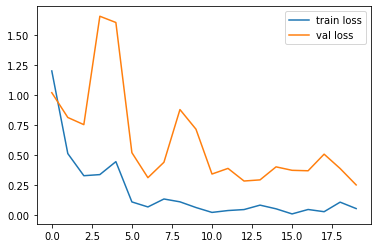

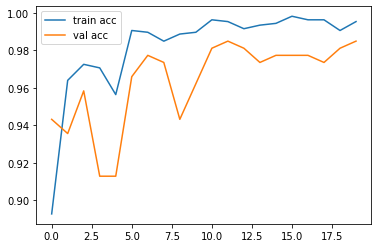

<Figure size 432x288 with 0 Axes>

In [37]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [38]:
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix , classification_report
import pandas as pd
import seaborn as sns

In [40]:
############ Finding the Prediction on Test Images ###############


actual_label_array = np.zeros((test_set.n), dtype=np.float32)
predicted_output_array = np.zeros((test_set.n), dtype=np.float32)

total_test_batches = len(test_set)

lower_index = 0

for i in range(total_test_batches):
  tmp_set = test_set.next()
  out_put = MobileNet_V2_model_renamed.predict( tmp_set[0] )
  upper_index = lower_index + out_put.shape[0]
  print("Processing Batch Number: ", i )
  # print(lower_index, upper_index, out_put.shape) 
  predicted_output_array[ lower_index : upper_index ] = np.argmax(out_put , axis=1)  
  actual_label_array[ lower_index : upper_index ] = np.argmax(tmp_set[1] , axis=1) 
  lower_index = upper_index
     

print( "Actual Test Labels: ", actual_label_array )
print( "Predicted Test Labels: ",  predicted_output_array )

Processing Batch Number:  0
Processing Batch Number:  1
Processing Batch Number:  2
Processing Batch Number:  3
Processing Batch Number:  4
Processing Batch Number:  5
Processing Batch Number:  6
Processing Batch Number:  7
Processing Batch Number:  8
Actual Test Labels:  [0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1.
 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1.
 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1.
 0. 0. 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 1.
 0. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0.
 1. 0. 1. 0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1.
 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0.
 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1.
 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 

In [41]:
# Source code credit for this function: https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('Truth')
    plt.xlabel('Prediction')

In [42]:
truth =actual_label_array
prediction = predicted_output_array

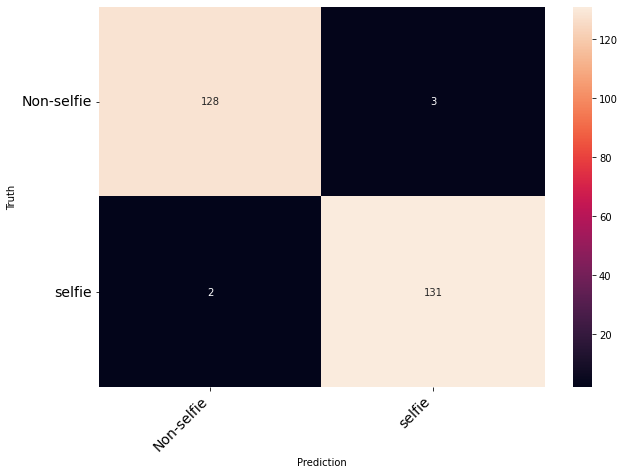

In [43]:
cm = confusion_matrix(truth,prediction)
print_confusion_matrix(cm,["Non-selfie","selfie"])

In [44]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
pre = precision_recall_fscore_support (actual_label_array, predicted_output_array, average='micro')

print("Showing Precision: ")
print(precision_score(actual_label_array, predicted_output_array, average="macro"))
print("Showing Recall: ")
print(recall_score(actual_label_array, predicted_output_array, average="macro"))    
print("Showing F1 Score : ")
print(f1_score(actual_label_array, predicted_output_array, average="macro"))

Showing Precision: 
0.9811136624569461
Showing Recall: 
0.9810308213281295
Showing F1 Score : 
0.9810581600585475
